## DNN Model for the classification of cancer types

## DNN Model (without_outliers)

## Imports

In [18]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Bidirectional, Flatten, GRU, Reshape
from keras.optimizers import SGD, Adam, Adamax, RMSprop, Adagrad
from keras.metrics import AUC, Accuracy, CategoricalAccuracy, sparse_categorical_accuracy
from tensorflow.keras import layers, activations
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner as kt
from statistics import mean
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import imblearn
from collections import Counter
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import keras.backend as K
from sklearn.metrics import classification_report, confusion_matrix


### Useful functions

In [19]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [20]:
class MulticlassTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='multiclass_true_positives', **kwargs):
        super(MulticlassTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)

## Load Data

In [21]:
#load dataframe
#outlier_folder = "with_outliers"
outlier_folder = "without_outliers"
df_genes_labels_file = f'Data/{outlier_folder}/df_genes_labels_without_outliers_tmm.pkl'

if os.path.exists(df_genes_labels_file):
    df_genes_labels = pd.read_pickle(df_genes_labels_file)
else:
    raise Exception("You need to run the notebook \"PrepareDataExploratoryAnalysis\".")

df_genes_labels_file = f'Data/{outlier_folder}/df_expression_data_lasso_tmm.pkl'
if os.path.exists(df_genes_labels_file):
    df_genes_labels_selected = pd.read_pickle(df_genes_labels_file)
else:
    raise Exception("You need to run the notebook \"ReduceDimensionality\".")

labels = df_genes_labels.iloc[:, 5441:5442]

df_genes_labels_selected['Patient_group'] = labels

print(f'Number of types of cancer: \n {len(labels.value_counts())} \n')
print(f'Total number of samples: \n {len(labels)} \n')
print(f'Number of features: \n {len(df_genes_labels_selected.columns) -1} \n')
print(f'Number of samples by type of cancer: \n {labels.value_counts()} \n')

Number of types of cancer: 
 19 

Total number of samples: 
 2307 

Number of features: 
 32 

Number of samples by type of cancer: 
 Patient_group
0                700
2                510
7                141
1                132
3                125
5                101
4                 93
11                85
8                 84
6                 68
10                51
13                39
16                35
9                 31
17                28
18                28
12                23
15                20
14                13
Name: count, dtype: int64 



In [22]:
# Remove cancer types with less than 28 samples
#counts = df_genes_labels_selected['Patient_group'].value_counts()
#categories_to_maintain = counts[counts >= 28].index
#df_genes_labels_selected = df_genes_labels_selected[df_genes_labels_selected['Patient_group'].isin(categories_to_maintain)]
#counts = df_genes_labels_selected['Patient_group'].value_counts()
#print(f'Number of types of cancer: \n {len(counts)} \n')
#print(f'Number of samples by type of cancer: \n {counts} \n')


In [23]:
labels = df_genes_labels_selected['Patient_group']
df_genes_labels_selected = df_genes_labels_selected.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(df_genes_labels_selected, labels, test_size=0.2, random_state=42, shuffle=True)

print(f'Cantidad de elementos por clase en TRAIN: \n {y_train.value_counts()} \n')
print(f'Cantidad de elementos por clase en TEST: \n {y_test.value_counts()}')

Cantidad de elementos por clase en TRAIN: 
 Patient_group
0     559
2     407
7     117
1     107
3     100
4      81
5      77
11     73
8      68
6      51
10     44
13     33
16     24
17     23
9      21
18     20
15     16
12     15
14      9
Name: count, dtype: int64 

Cantidad de elementos por clase en TEST: 
 Patient_group
0     141
2     103
3      25
1      25
7      24
5      24
6      17
8      16
11     12
4      12
16     11
9      10
12      8
18      8
10      7
13      6
17      5
14      4
15      4
Name: count, dtype: int64


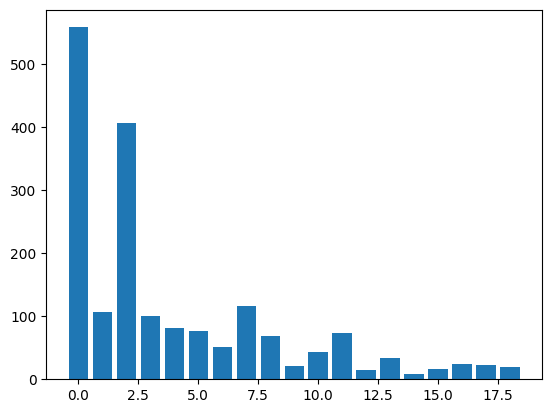

In [24]:
# summarize distribution
counter = Counter(y_train)
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
#plt.xlim(0, 28)
pyplot.show()

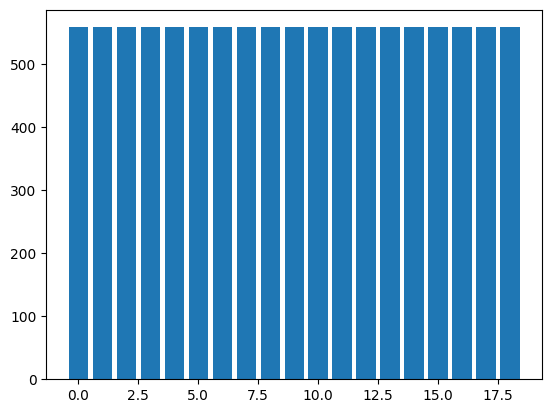

In [25]:
X, y = SMOTE(k_neighbors=2).fit_resample(X_train, y_train)
# summarize distribution
counter = Counter(y)
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [26]:
# Create Model. Reference: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-022-04980-9#Tab2

def model_builder(hp):
    classifier = Sequential()
    #hp_units_first_layer = hp.Int('units', min_value = 1024, max_value = 1024, default = 64, step = 32)
    classifier.add(Dense(units = 1024, activation = 'relu', input_dim = 32))
    classifier.add(Reshape((32, 32, 1)))
    #hp_filters_first_conv = hp.Int('units', min_value = 128, max_value = 128, default = 128, step = 32)
    classifier.add(Conv2D(filters = 128, kernel_size = 3, padding='same', strides = 2, activation='relu'))
    classifier.add(MaxPool2D(pool_size = (2,2), strides = 2))
    #classifier.add(Bidirectional(GRU(64, return_sequences = True, bias_regularizer=tf.keras.regularizers.l2(1e-4),
    #                                     activity_regularizer=tf.keras.regularizers.l2(1e-5))))
    #hp_filters_second_conv = hp.Int('units', min_value = 64, max_value = 64, default = 64, step = 32)
    classifier.add(Conv2D(filters = 64, kernel_size = 3, padding='same', strides = 2, activation='relu'))
    classifier.add(MaxPool2D(pool_size = (2,2), strides = 2))
    classifier.add(Flatten())
    classifier.add(Dense(128,activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2()))
    classifier.add(Dense(64,activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2()))
    classifier.add(Dropout(rate=0.6))
    classifier.add(Dense(32,activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2()))
    classifier.add(Dropout(rate=0.2))
    classifier.add(Dense(19,activation = 'softmax'))   
    
    #hp_learning_rate = hp.Float('lr', min_value=1e-8, max_value=1e-2, sampling="log")
    #optimizers_dict = {
    #        "Adam": Adam(learning_rate=hp_learning_rate),
    #        "Adamax": Adamax(learning_rate=hp_learning_rate),
    #        "SGD": SGD(learning_rate=hp_learning_rate),
    #        "Adagrad": Adagrad(learning_rate=hp_learning_rate),
    #        "RMSprop": RMSprop(learning_rate=hp_learning_rate)
    #        }
    
    #hp_optimizers = hp.Choice(name = 'optimizer', 
    #    values=['Adam', 'Adamax', 'SGD', 'Adagrad', 'RMSprop']
    #    )
        
        
    metrics=['accuracy',
                       keras.metrics.categorical_accuracy,
                       tf.keras.metrics.TopKCategoricalAccuracy(k=5),
                       MulticlassTruePositives()]
    
    classifier.compile(optimizer='Adam',
                loss = 'sparse_categorical_crossentropy', 
                metrics = metrics)

    return classifier

In [27]:
tuner = kt.BayesianOptimization(
    hypermodel=model_builder,
    objective= kt.Objective('val_accuracy', direction='max'),
    max_trials=40,    
    directory = 'Data/model_tests',
    project_name = 'cancer_MultiCLass_classif_CNN_tmm',
    overwrite = True
)
tuner.search_space_summary()

Search space summary
Default search space size: 0


In [28]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('Data/models/best_multiclass_model_CNN_tmm.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early, checkpoint])

Trial 1 Complete [00h 00m 37s]
val_accuracy: 0.46883469820022583

Best val_accuracy So Far: 0.46883469820022583
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit


In [29]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
44/47 [===========================>..] - ETA: 0s - loss: 4.8402 - accuracy: 0.2315 - categorical_accuracy: 0.6676 - top_k_categorical_accuracy: 0.9638 - multiclass_true_positives: 326.0000

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\keras\src\engine\training.py:2620: UserWarning: Metric MulticlassTruePositives implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


47/47 [==============================] - 2s 22ms/step - loss: 4.8046 - accuracy: 0.2290 - categorical_accuracy: 0.6721 - top_k_categorical_accuracy: 0.9648 - multiclass_true_positives: 338.0000 - val_loss: 3.9284 - val_accuracy: 0.3279 - val_categorical_accuracy: 1.0000 - val_top_k_categorical_accuracy: 1.0000 - val_multiclass_true_positives: 121.0000
Epoch 2/100
47/47 [==============================] - 1s 16ms/step - loss: 3.4807 - accuracy: 0.2873 - categorical_accuracy: 0.8028 - top_k_categorical_accuracy: 1.0000 - multiclass_true_positives: 424.0000 - val_loss: 2.9468 - val_accuracy: 0.3279 - val_categorical_accuracy: 1.0000 - val_top_k_categorical_accuracy: 1.0000 - val_multiclass_true_positives: 121.0000
Epoch 3/100
47/47 [==============================] - 1s 16ms/step - loss: 2.9087 - accuracy: 0.3028 - categorical_accuracy: 0.7568 - top_k_categorical_accuracy: 1.0000 - multiclass_true_positives: 447.0000 - val_loss: 2.6464 - val_accuracy: 0.3604 - val_categorical_accuracy: 0.87

In [30]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/17
45/47 [===========================>..] - ETA: 0s - loss: 4.8269 - accuracy: 0.1437 - categorical_accuracy: 0.2819 - top_k_categorical_accuracy: 0.6250 - multiclass_true_positives: 207.0000

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\keras\src\engine\training.py:2620: UserWarning: Metric MulticlassTruePositives implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


47/47 [==============================] - 2s 22ms/step - loss: 4.7999 - accuracy: 0.1484 - categorical_accuracy: 0.2893 - top_k_categorical_accuracy: 0.6328 - multiclass_true_positives: 219.0000 - val_loss: 3.6268 - val_accuracy: 0.3279 - val_categorical_accuracy: 1.0000 - val_top_k_categorical_accuracy: 1.0000 - val_multiclass_true_positives: 121.0000
Epoch 2/17
47/47 [==============================] - 1s 16ms/step - loss: 3.4071 - accuracy: 0.2575 - categorical_accuracy: 0.5813 - top_k_categorical_accuracy: 0.9743 - multiclass_true_positives: 380.0000 - val_loss: 3.0156 - val_accuracy: 0.3279 - val_categorical_accuracy: 1.0000 - val_top_k_categorical_accuracy: 1.0000 - val_multiclass_true_positives: 121.0000
Epoch 3/17
47/47 [==============================] - 1s 17ms/step - loss: 2.8731 - accuracy: 0.2608 - categorical_accuracy: 0.7154 - top_k_categorical_accuracy: 0.9986 - multiclass_true_positives: 385.0000 - val_loss: 2.5621 - val_accuracy: 0.3279 - val_categorical_accuracy: 1.0000

In [31]:
# Evaluate the result
eval_result = model.evaluate(X_test, y_test)
print(f"test loss: {eval_result[0]}, test accuracy: {eval_result[1]}")

15/15 [==============================] - 0s 6ms/step - loss: 2.1777 - accuracy: 0.4394 - categorical_accuracy: 0.5476 - top_k_categorical_accuracy: 0.7208 - multiclass_true_positives: 203.0000
test loss: 2.177687168121338, test accuracy: 0.43939393758773804


c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\keras\src\engine\training.py:2620: UserWarning: Metric MulticlassTruePositives implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


In [32]:
y_pred = model.predict(X_test)
predict = y_pred.argmax(axis=1)
print(classification_report(y_test, predict))

15/15 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.51      0.91      0.65       141
           1       0.00      0.00      0.00        25
           2       0.48      0.67      0.56       103
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        12
           5       0.17      0.08      0.11        24
           6       0.00      0.00      0.00        17
           7       0.08      0.17      0.11        24
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00        12
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         4
          16       0.00     

c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Edel\.virtualenvs\Desarrollo-OyWcDdAp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

<Axes: >

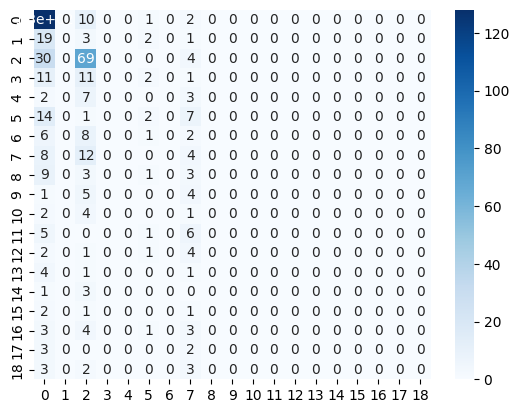

In [33]:
cm = confusion_matrix(y_test, predict)
#sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
sns.heatmap(cm, annot=True, cmap='Blues')